In [937]:
import os, re, logging
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns

In [981]:
BASE = '/Users/anne/repos/RPA/resources/'
FILENAME = '20140718_dutchdictionary.txt'
PATH_TO_DATA = '/Users/anne/surfdrive/uva/projects/RPA_KeepingScore/pickle_files/'

MINNUMBERMATCHES = 2 # min number of times a keyword should occur for a topic to be present

In [1008]:
def label_topic(x):
    if x == '1':
        return 'Macro-economie en belastingen'
    if x == '2':
        return 'Burgerrechten en vrijheden'
    if x == '3':
        return 'Gezondheid'
    if x == '4':
        return 'Landbouw en Visserij'
    if x == '5':
        return 'Arbeid'
    if x == '6':
        return 'Onderwijs'
    if x == '7':
        return 'Milieu'
    if x == '8':
        return 'Energiebeleid'
    if x == '9':
        return 'Immigratie en integratie'
    if x == '10':
        return 'Verkeer en vervoer'
    if x == '11':
        return 'Unkown'
    if x == '12':
        return 'Justitie, Rechtspraak, Criminaliteit'
    if x == '13':
        return 'sociale Zaken'
    if x == '14':
        return 'Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning'
    if x == '15':
        return 'Ondernemingen, Bankwezen en binnenlandse handel '
    if x == '16':
        return 'Defensie'
    if x == '17':
        return 'Wetenschappelijk onderzoek, technologie en communicatie'
    if x == '18':
        return 'Buitenlandse handel'
    if x == '19':
        return 'Buitenlandse zaken en ontwikkelingssamenwerking'
    if x == '20':
        return 'Functioneren democratie en openbaar bestuur'
    if x == '21':
        return 'Ruimtelijke ordening, publiek natuur- en waterbeheer'
    if x == '22':
        return 'Unkown 2'
    if x == '23':
        return 'Kunst, cultuur en entertainment'
    if x == '24':
        return '*** Gemeentelijk en provinciaal bestuur'
    if x == '29':
        return '*** Sport'
    if x == '00':
        return 'Toegevoegde codes voor media'
    
def parse_xml():
    'reads file with topic numbers + words and parses the title'
    words = []
    topics = []
    for l in [line.strip() for line in open(os.path.join(BASE, FILENAME)).readlines() if len(line)>1] :
        topics_words = defaultdict(list)
        if l.startswith('<cnode'):
            wordlist = []
            topics_l = list(re.sub('">|"|t', '', l.split('=')[1]) )
            if len(topics_l) == 2 :
                final_topic = "".join(topics_l)
            elif len(topics_l) == 3 :
                final_topic = topics_l[0]
            elif len(topics_l) == 4 :
                final_topic = "".join( topics_l[:2] )
        elif l.startswith('<pnode'):
            word = re.sub('">|</pnode>|"', '', l.split('=')[1]) 
            #print('here comes the first word: {}'.format(word))
            words.append(word)
            topics.append(final_topic)
    return words, topics

def get_dict():
    'returns a dict with keys = topic, values = words '
    words, topics = tryout()
    d = defaultdict(list)
    for topic, word in zip(topics, words):
        topic_name = label_topic(topic)
        #print(topic_name)
        d[topic_name].append(word)
    return d

def get_stemmed_dict():
    stemmer = SnowballStemmer("dutch")
    d = get_dict()
    stemmed_dictionary = {}
    for topic, words in d.items():
        stemmed_dictionary[topic] = [ stemmer.stem(w) for w in words ]
    return stemmed_dictionary


def get_raw_data():
    df = pd.read_pickle(PATH_TO_DATA + 'VK_TEL')
    df = df[['text_title', 'main_topic', 'main_topic_label']]
    df.rename(columns={'text_title' : 'text', 'main_topic' : 'topic'}, inplace = True)
    df['origin'] = 'RPA'
    df.reset_index(drop=True, inplace=True)
    df['documentnr'] = df.index
    return df

def get_bjorn_data():
    df = pd.read_pickle(PATH_TO_DATA + 'dataset_burscher.pkl')
    df['origin'] = 'Bjorn'
    return df
    
def get_recode_data():
    'match data according to coding of Bjorn'
    df = get_raw_data()
    a = ['Buitenlandse handel' , 'Kunst, cultuur en entertainment' ,  'Ruimtelijke ordening, publiek natuur- en waterbeheer', 'Toegevoegde codes voor media'] 
    b = ['Overige' ] * len(a)
    overige_cat = dict(zip(a,b))
    df['main_topic_label'].replace(overige_cat, inplace = True)
    return df

def get_data():
    df = get_recode_data().append(get_bjorn_data())
    df.reset_index(drop=True, inplace=True)
    df['documentnr'] = df.index
    return df

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def return_stemmed_text_columns():
    df = get_data()
    df['stemmed_text'] = df.text.apply(stem_sentences)
    return df

def dictionary_topics():
    df1 = return_stemmed_text_columns()
    result = []
    documentnr = -1
    for document in df1['text']:
        documentnr += 1
        topics_per_document = {}
        d = get_dict()
        for topic, words in d.items():
            match = [x for x in words if x in document.lower().split(' ')]
            doc_string = document.lower().split(' ')
            index = [doc_string.index(word) for word in match ]
            try:
                index_smallest = min(index)
            except:
                index_smallest = np.nan

            topics_per_document = {'documentnr' : documentnr, 
                                    'topic_label_dictionary': topic, 
                                    'index_words' : index, 
                                    'smallest_index' : index_smallest,
                                    'len matches' : len(match),
                                    'words matches' : match  ,
                                    'text' : document.lower()}
            result.append(topics_per_document)
    return result

def dictionary_topics_stemmed():
    df1 = return_stemmed_text_columns()
    result = []
    documentnr = -1
    for document in df1['stemmed_text']:
        documentnr += 1
        topics_per_document = {}
        d = get_stemmed_dict()
        for topic, words in d.items():
            match = [x for x in words if x in document.lower().split(' ')]
            doc_string = document.lower().split(' ')
            index = [doc_string.index(word) for word in match ]
            try:
                index_smallest = min(index)
            except:
                index_smallest = np.nan
        #    index = x for x in match .index(word)

            topics_per_document = {'documentnr' : documentnr, 
                                    'stemmed_topic_label_dictionary': topic, 
                                    'stemmed_index_words' : index, 
                                    'stemmed_smallest_index' : index_smallest,
                                    'stemmed_len matches' : len(match),
                                    'stemmed_words matches' : match  ,
                                    'stemmed_text' : document.lower()}
            result.append(topics_per_document)
    return result


def get_merged_df():
    'returns a df with number of topics as identified by the dictionary approach'
    result = dictionary_topics()
    stemmed_results = dictionary_topics_stemmed()
    df2 = pd.DataFrame.from_dict(result)
    df2 = (df2.assign(to_sort = df2.smallest_index.abs()).sort_values('to_sort').drop_duplicates('documentnr').drop(columns='to_sort'))
    df2 = df2[np.isfinite(df2['smallest_index'])]
    df3 = pd.DataFrame.from_dict(stemmed_results)
    df3 = (df3.assign(to_sort = df3.stemmed_smallest_index.abs()).sort_values('to_sort').drop_duplicates('documentnr').drop(columns='to_sort'))
    df3 = df3[np.isfinite(df3['stemmed_smallest_index'])]
    df1 = get_data()
    df = pd.merge(df1, df2, how= 'left', on = 'documentnr')
    df = pd.merge(df, df3, how = 'left', on='documentnr')
    df['topic_label_dictionary'].fillna(value='Overige', inplace = True)
    df['len matches'] = df['len matches'].fillna(0)
    df['stemmed_topic_label_dictionary'].fillna(value='Overige', inplace = True)
    df['stemmed_len matches'] = df['stemmed_len matches'].fillna(0)
    return df

def recode_dictionary():
    '''recode categories so to match Bjorns' scoring'''
    df = get_merged_df()
    a = ['Buitenlandse handel' , 'Kunst, cultuur en entertainment' ,'*** Sport', 'Ruimtelijke ordening, publiek natuur- en waterbeheer', 'Toegevoegde codes voor media'] 
    b = ['Overige' ] * len(a)
    overige_cat = dict(zip(a,b))
    df['main_topic_label'].replace(overige_cat, inplace = True)
    df['topic_label_dictionary'].replace(overige_cat, inplace = True)
    df['stemmed_topic_label_dictionary'].replace(overige_cat, inplace = True)
    print("the length of categories identified by dict is now: {} ".format(len(df['topic_label_dictionary'].unique()) ) )
    print("...and the stemmed dict: {} ".format(len(df['stemmed_topic_label_dictionary'].unique()) ) )
    return df

# specify how many words should match before the topic is considered present:
def apply_minnummatches():
    df = recode_dictionary()
    df['topic_label_dictionary_minmatches'] = np.where(df['len matches'] < MINNUMBERMATCHES, 'Overige', df['topic_label_dictionary'])
    df['topic_label_dictionary_minmatches_stem'] = np.where(df['stemmed_len matches'] < MINNUMBERMATCHES, 'Overige', df['stemmed_topic_label_dictionary'])
   # print(df[['topic_label_dictionary_minmatches', 'topic_label_dictionary_minmatches_stem','topic_label_dictionary', 'len matches' , 'main_topic_label'] ].head(5) )
    return df

# create columns with true postiives, false positives, and false negatives
def get_tp_fp_fn():
    df = apply_minnummatches()
    topics = list(df['main_topic_label'].unique())
    
    for topic in topics:
        columnname_tp = "_tp " + topic
        columnname_fp = "_fp " + topic
        columnname_fn = "_fn " + topic
        
        # and for stemmed
        
        columnname_tp_st = "st_tp " + topic
        columnname_fp_st = "st_fp " + topic
        columnname_fn_st = "st_fn " + topic
        
        # true positives = dictionary correctly identified.
        df[columnname_tp] = np.where( (df['main_topic_label'] == topic) & (df['topic_label_dictionary_minmatches'] == topic) , 1, 0 )
        # false positive = dictionary identified, but golden standard not. 
        df[columnname_fp] = np.where( (df['main_topic_label'] != topic) & (df['topic_label_dictionary_minmatches'] == topic) , 1, 0 )
        # false negative = dictionary NOT identified, but golden standard DID identify 
        df[columnname_fn] = np.where( (df['main_topic_label'] == topic) & (df['topic_label_dictionary_minmatches'] != topic) , 1, 0 )
        
        # and for stemmed
        # true positives = dictionary correctly identified.
        df[columnname_tp_st] = np.where( (df['main_topic_label'] == topic) & (df['topic_label_dictionary_minmatches_stem'] == topic) , 1, 0 )
        # false positive = dictionary identified, but golden standard not. 
        df[columnname_fp_st] = np.where( (df['main_topic_label'] != topic) & (df['topic_label_dictionary_minmatches_stem'] == topic) , 1, 0 )
        # false negative = dictionary NOT identified, but golden standard DID identify 
        df[columnname_fn_st] = np.where( (df['main_topic_label'] == topic) & (df['topic_label_dictionary_minmatches_stem'] != topic) , 1, 0 )
 
    return df

#df['_fp Overige'].value_counts()

In [954]:
# print dataframe, transformed: grouped by document and only the max length matches
#idx = df2.groupby(['documentnr'], sort=False)['len matches'].transform(max) == df2['len matches']
#df2[idx].head()

In [959]:
# describe
#df['n'] = 1
#df.groupby(df.main_topic_label).agg({'n' :'sum'})

#fig = plt.figure(figsize=(8,6))
#df.groupby('topic_label_dictionary_minmatches').text_x.count().sort_values().plot.barh(ylim=0, title= 'N ANNOTATIONS PER CATEGORY\n')
#plt.show()

In [1009]:
def get_recall_precision():
    
    true_positives = ["_tp " + i for i in topics]
    false_positives = ["_fp " + i for i in topics]
    false_negatives = ["_fn " + i for i in topics]
    
    true_positives_st = ["st_tp " + i for i in topics]
    false_positives_st = ["st_fp " + i for i in topics]
    false_negatives_st = ["st_fn " + i for i in topics]
   
    recall = {}
    precision = {}
    
    recall_stemmed = {}
    precision_stemmed = {}
    
    for tp, fp, fn, st_tp, st_fp, st_fn, topic in zip(true_positives, false_positives, false_negatives, true_positives_st, false_positives_st, false_negatives_st, topics) :   
        
        recall['recall ' + topic] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fn].sum(axis=0) )
        precision['precision ' + topic] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fp].sum(axis=0) )
        
        recall_stemmed['recall ' + topic] = df[st_tp].sum(axis=0) / ( df[st_tp].sum(axis=0) + df[st_fn].sum(axis=0) )
        precision_stemmed['precision ' + topic] = df[st_tp].sum(axis=0) / ( df[st_tp].sum(axis=0) + df[st_fp].sum(axis=0) )

    recall['recall total'] = sum(recall.values()) / len(recall.values())
    precision['precision total'] = sum(precision.values()) / len(precision.values())
    recall_stemmed['recall total'] = sum(recall_stemmed.values()) / len(recall_stemmed.values())
    precision_stemmed['precision total'] = sum(precision_stemmed.values()) / len(precision_stemmed.values())
    
    return recall, precision, recall_stemmed, precision_stemmed

In [1010]:
# get final df:
df = get_tp_fp_fn()

# check whether all went ok
df[df['main_topic_label'] == 'Overige'][['main_topic_label', 'topic_label_dictionary_minmatches', '_tp Overige', '_fp Overige', '_fn Overige']].head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To ac

the length of categories identified by dict is now: 20 
...and the stemmed dict: 20 


,main_topic_label,topic_label_dictionary_minmatches,_tp Overige,_fp Overige,_fn Overige
29,Overige,Overige,1,0,0
38,Overige,Overige,1,0,0
39,Overige,Overige,1,0,0
108,Overige,"Ondernemingen, Bankwezen en binnenlandse handel",0,0,1
131,Overige,"Justitie, Rechtspraak, Criminaliteit",0,0,1
135,Overige,Overige,1,0,0
144,Overige,Overige,1,0,0
210,Overige,Overige,1,0,0
217,Overige,Overige,1,0,0
222,Overige,Overige,1,0,0


In [1011]:
df.to_pickle(PATH_TO_DATA + 'all_data.pkl')

In [1012]:
#get precision and recall for dictionary items
recall, precision, recall_stemmed, precision_stemmed = get_recall_precision()

In [1013]:
for t, s in recall.items():
    print('{} -- {}'.format(t, s))
    
print()

for t, s in precision.items():
    print('{} -- {}'.format(t, s))

print()

    
for t, s in recall_stemmed.items():
    print('{} -- {}'.format(t, s))
    
print()

for t, s in precision_stemmed.items():
    print('{} -- {}'.format(t, s))

recall Onderwijs -- 0.4835680751173709
recall Burgerrechten en vrijheden -- 0.016853932584269662
recall Justitie, Rechtspraak, Criminaliteit -- 0.1832797427652733
recall Defensie -- 0.22727272727272727
recall Gezondheid -- 0.30406852248394006
recall Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning -- 0.072992700729927
recall Functioneren democratie en openbaar bestuur -- 0.02257636122177955
recall Macro-economie en belastingen -- 0.16818181818181818
recall Buitenlandse zaken en ontwikkelingssamenwerking -- 0.03197925669835782
recall Ondernemingen, Bankwezen en binnenlandse handel  -- 0.12152777777777778
recall Arbeid -- 0.11814345991561181
recall Verkeer en vervoer -- 0.12560386473429952
recall Overige -- 0.9438361719383617
recall sociale Zaken -- 0.014388489208633094
recall Immigratie en integratie -- 0.11049723756906077
recall Landbouw en Visserij -- 0.5
recall Energiebeleid -- 0.14583333333333334
recall Milieu -- 0.09036144578313253
recall Wetenschappelijk onderzo

In [ ]:
# visualize 

In [1014]:
len(df['topic_label_dictionary_minmatches'].unique())

19

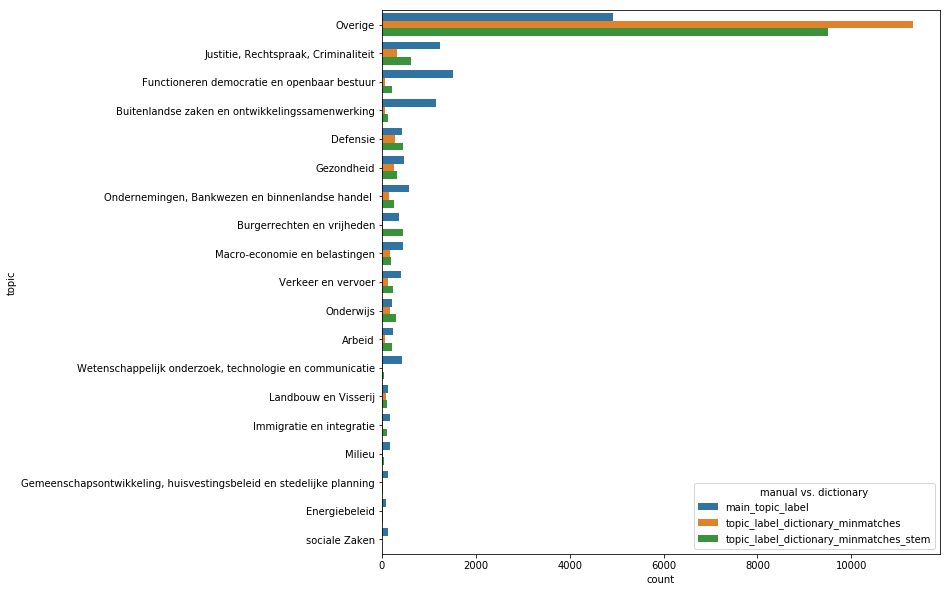

In [1015]:
df['id'] = df.index
melted = pd.melt(df, id_vars=['id'], value_vars=['main_topic_label', 'topic_label_dictionary_minmatches','topic_label_dictionary_minmatches_stem'], var_name='manual vs. dictionary', value_name='topic')

plt.rcParams['figure.figsize']=(10,10)
ax = sns.countplot(y="topic", hue='manual vs. dictionary', 
                   order = melted['topic'].value_counts().index, data=melted)

In [1022]:
pl = pd.read_csv('/Users/anne/Desktop/kamervragen3.csv', sep='±', error_bad_lines=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
Skipping line 1734: Expected 8 fields in line 1734, saw 9
Skipping line 2073: Expected 8 fields in line 2073, saw 9
Skipping line 2490: Expected 8 fields in line 2490, saw 9
Skipping line 3221: Expected 8 fields in line 3221, saw 9
Skipping line 4935: Expected 8 fields in line 4935, saw 9


In [1061]:
pl['type'].unique()
#pd.to_datetime(pl['type'], format='%d-%m-%Y')

pd['type'].apply(lambda x: dt.datetime.strptime(x,'%d-%m-%Y'))


TypeError: 'module' object is not subscriptable

In [1081]:
date = pl['type'].to_list()
date[1]


nan

In [ ]:
for i in 

In [1076]:
def parse_date(row):
    for i in row['type']:
        try:
            my_time = dateutil.parser.parse(i)
        except:
            my_time = 'NaN'
        return my_time
        

pl.apply(lambda row: parse_date(row), axis = 1)

3
3


TypeError: ("'float' object is not iterable", 'occurred at index 2')

In [1082]:
from dateutil.parser import parse

date_new = []
for i in date:
    try:
        my_time = parse(i)
    except:
        my_time = 'NaN'
    date_new.append(my_time)

In [1153]:
def parse_date(row):
   # for i in row['type']:
    try:
       # print(row)
        my_time = pd.to_datetime(row)
    except:
        my_time = 'NaN'
    return my_time
        
pl['date'] = pl['type'].apply(lambda row: parse_date(row))


In [1167]:
pl

,counter,file,type,datum,naam,onderwerp,vraag,new_date,date,id_number
1,ah-tk-19951996-10.xml,vraagDocument,30-8-1995,[Van der Hoeven],Vragen van het lid Van der Hoeven (CDA) over d...,Wat is de exacte stand van zaken met betrekkin...,8e947dd2b8464663eb834618a83bf24ab3db54c6,1995-08-30 00:00:00,1995-08-30,10
2,ah-tk-19951996-100.xml,"Geen goed bestand, waarschijnlijk HTML: The st...",NaN,None,None,None,None,NaN,NaT,100
3,ah-tk-19951996-1000.xml,vraagDocument,21-3-1996,[Van den Doel],Vragen van het lid Van den Doel (VVD) over gre...,Wordt intensievere samenwerking tussen de Nede...,0a20609c89f15b790d2817825b6cbaeb8a2e9216,1996-03-21 00:00:00,1996-03-21,1000
4,ah-tk-19951996-1001.xml,vraagDocument,14-3-1996,[Augusteijn-Esser][Te Veldhuis],Vragen van de leden Augusteijn-Esser (D66) en ...,Wat zijn de redenen om de subsidie aan het WHO...,ac942e697c6665328436b239e184dd2c58aee0bf,1996-03-14 00:00:00,1996-03-14,1001
5,ah-tk-19951996-1002.xml,vraagDocument,22-3-1996,[Van Middelkoop],Vragen van het lid Van Middelkoop (GPV) over h...,"Komt het voor, dat melkveehouders onderling hu...",1af1427709a84eeb13eab0b5cbc6a90a39876779,1996-03-22 00:00:00,1996-03-22,1002
6,ah-tk-19951996-1003.xml,vraagDocument,26-3-1996,[Sipkes],Vragen van het lid Sipkes (GroenLinks) over de...,"Kunt u het bericht bevestigen, dat de criminel...",69f3e93a91d5f25d471933092f74cb62227eeee2,1996-03-26 00:00:00,1996-03-26,1003
7,ah-tk-19951996-1004.xml,vraagDocument,21-3-1996,[Huys],Vragen van het lid Huys (PvdA) over verminderi...,"Kent u de berichten dat de L.L.T.B., de Milieu...",4168b029a8566e9864038d3e373e78a5ea792dd2,1996-03-21 00:00:00,1996-03-21,1004
8,ah-tk-19951996-1005.xml,vraagDocument,21-3-1996,[Stellingwerf],Vragen van het lid Stellingwerf (RPF) over onk...,Bent u op de hoogte van de positieve resultate...,2d67b5690acc8647787e9a3c30a031e2bea781f5,1996-03-21 00:00:00,1996-03-21,1005
9,ah-tk-19951996-1006.xml,vraagDocument,10-4-1996,[H. G. J. Kamp],Vragen van het lid H. G. J. Kamp (VVD) over ki...,Kent u de conclusie ´De geteste produkten om k...,e709f0fa750683f0aea3e24ee8d5c3d5f4c3d7a9,1996-10-04 00:00:00,1996-10-04,1006
10,ah-tk-19951996-1007.xml,vraagDocument,28-3-1996,[Soutendijk-van Appeldoorn],Vragen van het lid Soutendijk-van Appeldoorn (...,Kent u de recente berichtgeving over de positi...,cc47e776a7f0de1d4a9a78fe8310cf6428120d29,1996-03-28 00:00:00,1996-03-28,1007


In [1168]:
def parse_identifier(row):
    return row.replace('.', '-').split('-')[-2]

def parse_identifier_d(row):
    return row.replace('.', '-').split('-')[-3]

pl['id_number'] = pl['counter'].apply(lambda row: parse_identifier(row))

In [1170]:
pl['id_date'] =  pl['counter'].apply(lambda row: parse_identifier_d(row))

In [1179]:
pl[['id_date', 'date']].head(10)
pl['id_date'].unique()

array(['19951996', '19961997', '19971998', '19981999', '19992000',
       '20002001', '20012002', '20022003', '20032004', '20042005',
       '20052006', '20062007', '20072008', '20082009', '20092010',
       '20102011', '20112012', '20122013', '20132014', '20142015',
       '20152016', '20162017'], dtype=object)

In [1141]:
#pd.to_datetime(pl.type, format = '%d-%m-%Y', errors="raise")

pl['type'].apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y'))

ValueError: time data '1996' does not match format '%d-%m-%Y' (match)

In [1132]:
pd.DatetimeIndex(pl['new_date']).year

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 200-03-19 00:00:00

In [1094]:
pd.to_datetime(pl['new_date'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 200-03-19 00:00:00